# Question 1: Variational Autoencoder
**Make sure you have read the theoretical assignment, and answered the questions there, before working on this practical assignment.**

In this task, we will implement a Variational Autoencoder (VAE) step by step, using the model and results from the theoretical assignment. Some code is already provided, the task is to fill in the gaps.

In [0]:
abs_path = '/content/gdrive/My Drive/TUE -EIT (me)/Recommender Systems/Assignment 4 - Generative Models/'

### Imports

In [0]:
from keras.layers import Lambda, Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, BatchNormalization
from keras.models import Model, load_model, Sequential
from keras.datasets import mnist
from keras import backend as K

import math
import numpy as np
import matplotlib.pyplot as plt

### Data
We will train a VAE for the MNIST data. This code loads the data, and increases the canvas size to 32x32 by padding zeros. This makes it easier to design convolutional autoencoder architectures with striding or pooling/upsampling.

In [0]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalise
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# change shape: (n, 28, 28) -> (n, 28, 28, 1)
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

# pad zeros to obtain canvas size of 32x32, i.e. shape is now (n, 32, 32, 1)
x_train = np.pad(x_train, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)
x_test = np.pad(x_test, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)

# get height, width, and depth values
height, width, depth = x_train.shape[1:]

## Task 1.1: Encoder architecture
**(a)** *Choose and implement a suitable architecture for the encoder. The encoder should have two outputs, which we will interpret as the mean and log variance of the approximate posterior distribution $q(z|x)$ (a Gaussian, as defined in the theoretical assignment). In this task, use a latent space dimension of 2 such that we can easily plot the latent space.*

In [102]:
# network parameters
input_shape = (height, width, depth)
latent_dim = 2
dense1_dim = 1024
dense2_dim = 32

# VAE model = encoder + decoder
x_in = Input(shape=input_shape, name='encoder_input')

# build encoder model
#### INSERT CODE HERE
# conv block 1
h = Conv2D(filters=64, kernel_size=(3, 3), padding="same",
           activation='relu')(x_in)                    # (32, 32, 1)  -> (32, 32, 64)
h = MaxPooling2D(pool_size=(2, 2), padding="same")(h)  # (32, 32, 64) -> (16, 16, 64)
h = BatchNormalization()(h)                            # no change

# conv block 2
h = Conv2D(filters=128, kernel_size=(3, 3), padding="same",
           activation='relu')(h)                       # (16, 16, 64)  -> (16, 16, 128)
h = MaxPooling2D(pool_size=(2, 2), padding="same")(h)  # (16, 16, 128) -> (8, 8, 128)
h = BatchNormalization()(h)                            # no change

# dense layers
h = Flatten()(h)                                       # (8, 8, 128) -> (8*8*128,)
h = Dense(dense1_dim, activation="relu")(h)                   # (8*8*128,)  -> (1024,)
h = BatchNormalization()(h)                            # no change
h = Dense(dense2_dim, activation="relu")(h)                    # (1024,) -> (64,)
h = BatchNormalization()(h)                            # no change
# h = Dense(32)(h)                                       # (64,) -> (32,) (encoding dimension)
# h = BatchNormalization()(h)                            # no change
####

z_mean = Dense(latent_dim, name='z_mean')(h)  # mean parameter of q(z|x)
z_log_var = Dense(latent_dim, name='z_log_var')(h)  # log of variance parameter of q(z|x)

# instantiate encoder model
encoder = Model(x_in, [z_mean, z_log_var], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 32, 32, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_31 (MaxPooling2D) (None, 16, 16, 64)   0           conv2d_54[0][0]                  
__________________________________________________________________________________________________
batch_normalization_89 (BatchNo (None, 16, 16, 64)   256         max_pooling2d_31[0][0]           
__________________________________________________________________________________________________
conv2d_55 

**(b)** *Motivate your choice of architecture.*

**Answer:**

To design our architecture we followed the VGG one adapting it to our needs, which is having an latent state of size 2.

To do so, our flatten layer has 8192, which is 2^13. Since we need to end our latent state in 2, we configure the two last dense layers to downscale properly from 8192 to 2. That's why we chose a dense layer of 1024 (2^10) and a second dense layer of 32 (2^5), which is connected to the latent state of 2.

Other option would have been to stack more dense layers and downscaling more gradually, however, since we try to follow the VGG architecure, we remain just having 2 dense layers after the convolution layers.

**(c)** *What is the reason to model the logarithm of the variance, instead of the variance (or standard deviation) itself?*

**Answer:**


Since the value of the variance is going to be close to 0,  this will cause a serious underflow of the computer when computing the gradients with SGD. As a result of this, the estimation will be less precise. The way to avoid this problem is by alternatively computing the logarithm o the variance, which will give us negative values, but at least not close to 0.

Since the arg max will be the same for variance or log variance, in the end it will result in the same parameter. This is why we sue the log of the variance and, this is what they took into account in the original paper to customize the KL divergence loss function.


## Task 1.2: Decoder architecture
**(a)** *Choose and implement a suitable architecture for the decoder. Input is a sample of latent variables, the output represents the parameters of the generative distribution $p(x|z)$, i.e. the mean of a Gaussian distribution (for continuous data) or Bernoulli distribution (for binary data).*

In [103]:
# build decoder model
z_in = Input(shape=(latent_dim,), name='z_in')

#### INSERT CODE HERE
h = Dense(dense2_dim, activation="relu")(z_in)      # (2,) -> (64,) (encoding dimension)
h = BatchNormalization()(h)                 # no change
h = Dense(dense1_dim, activation="relu")(h)        # (64, -> (1024,)
h = BatchNormalization()(h)                 # no change
h = Dense(8*8*128, activation="relu")(h)    # (1024,)     -> (8*8*128,)
h = Reshape((8, 8, 128))(h)                 # (8*8*128,) -> (8, 8, 128)

# reverse conv block 2
h = BatchNormalization()(h)                 # no change
h = UpSampling2D(size=(2, 2))(h)            # (8, 8, 128  ) -> (16, 16, 128)
h = Conv2D(filters=64, kernel_size=(3, 3), padding="same",
           activation='relu')(h)            # (16, 16, 128) -> (16, 16, 64)

# reverse conv block 2
h = BatchNormalization()(h)                 # no change
h = UpSampling2D(size=(2, 2))(h)            # (16, 16, 64) -> (32, 32, 64)

# do we need this one????
dec_out = Conv2D(filters=1, kernel_size=(3, 3), padding="same",
               activation='sigmoid')(h)     # (32, 32, 64) -> (32, 32, 1)


# instantiate decoder model
decoder = Model(z_in, dec_out, name='decoder')
decoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_in (InputLayer)            (None, 2)                 0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                96        
_________________________________________________________________
batch_normalization_93 (Batc (None, 32)                128       
_________________________________________________________________
dense_37 (Dense)             (None, 1024)              33792     
_________________________________________________________________
batch_normalization_94 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_38 (Dense)             (None, 8192)              8396800   
_________________________________________________________________
reshape_14 (Reshape)         (None, 8, 8, 128)         0         
__________

**(b)** *Motivate your choice of architecture.*

**Answer:**

In the decoder the architecture needs to be symetric to the one of the encoder. So we instead of using MaxPool2D we use UpScale2D and we place the dense layers in reversed order, to have a symetric architecture with respect to the encoder.

## Load previously trained encoder & decoder
The following code should not be used the first time, if you haven't trained a VAE yet. After training a VAE, you can save your encoder & decoder model. This code can then be used to load these models again, such that you won't need to retrain a new model in each new session.

Note that we only load the separate encoder & decoder model, not the entire VAE model. The reason for this is that the VAE will contain a lambda layer, and Keras can have trouble saving/loading models with lambda layers.

In [4]:
# NOTE: DO NOT RUN THIS CODE THE FIRST TIME! Only use this to load encoder
#       and decoder models that you have trained before, to prevent having to
#       train a new VAE from scratch in each new session
from google.colab import drive
drive.mount('/content/gdrive')

encoder_path = abs_path + "vae_encoder_mnist.h5"
decoder_path = abs_path + "vae_decoder_mnist.h5"

encoder = load_model(encoder_path)
decoder = load_model(decoder_path)

encoder.summary()
decoder.summary()

x_in = encoder.input
z_mean, z_log_var = encoder.output
latent_dim = int(z_mean.shape[1])

W0614 11:55:41.894441 139734314190720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0614 11:55:41.930012 139734314190720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0614 11:55:41.945408 139734314190720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0614 11:55:41.958748 139734314190720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0614 11:55:41.959500 139734314190720 deprecation_wrap

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


W0614 11:55:42.856112 139734314190720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
W0614 11:55:44.389149 139734314190720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_2 (

## Task 1.3: Reparametrisation trick
*To implement sampling with the reparametrisation trick, we will define a custom lambda layer. It takes the mean and log variance of $q(z|x)$ as input, and outputs a sample from $q(z|x)$. This is done by first sampling from a standard Gaussian (Normal) distribution, and then applying the proper transformation to obtain a sample from $q(z|x)$ with the given mean and variance. Implement this transformation.*

In [0]:
def sampling(args):
    """Reparametrisation trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of q(z|x)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch_dim = K.shape(z_mean)[0]
    z_dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch_dim, z_dim))
    
    #### INSERT CODE HERE
    z = z_mean + K.exp(0.5 * z_log_var) * epsilon
    return z
    ####


# use reparametrisation trick to push the sampling out as input
z = Lambda(sampling, name='z')([z_mean, z_log_var])


# instantiate full VAE model
x_mean = decoder(z)
vae = Model(x_in, x_mean, name='vae')

## Task 1.4: Loss function
*Now we define the loss function, which you have derived in the theoretical part of the assignment. Note: we wish to maximise the ELBO, but Keras formulates training objectives as a loss function to minimise, so the loss function is the negative ELBO:*
$-\mathbb{E}_{q_\phi(z|x)} [\log p_\theta(x|z)] + KL(q_\phi(z|x) || p(z))$.

*We split this into two terms, the reconstruction loss and the KL loss.*


### Reconstruction loss
*We start with the first term: $-\mathbb{E}_{q_\phi(z|x)} [\log p_\theta(x|z)]$.*

*We approximate the expectation with a single Monte Carlo sample (using the reparametrisation trick such that the loss function is differentiable), which we can readily obtain from the sampling layer of our encoder model (output `z`). So all you need to implement is the loss function $-\log p_\theta(x|z_{sample})$. You've derived the formula for this in the theoretical part of the assignment, for both a Bernoulli distribution (for discrete data) and a Gaussian distribution with fixed standard deviation (for continuous data). Implement both versions here. Choose a suitable standard deviation value for the Gaussian.*

### KL loss
*The second term of the loss is the KL Divergence $KL(q_\phi(z|x) || p(z))$, which as we saw has a closed form for our choice of posterior and prior (both Gaussians):
$ \frac{1}{2} \sum_{k=1}^K (m_k^2 + s_k^2 - \log s_k^2 - 1)$ (see the theoretical part of the assignment for explanation of the notations). Implement it here.*


##### Implementation notes:
* Always use functions from the Keras backend (available through `from keras import backend as K`) for Tensor operations in your loss function. This way, Keras can perform automatic differentiation to compute the gradients for training. E.g. `K.sum(), K.square(), K.exp()`. You can use operators such as `+` and `*`, they will automatically convert to Tensor operations.
* Make sure to use `K.flatten(x_in)` and `K.flatten(x_mean)` whenever you need them in your loss functions, don't use `x_in` or `x_mean`. The `(height, width, depth)` structure of the data is only needed for convolutional layers, but not in the loss function.
* Note that the formulas you derived in the theoretical assignment are for a single data point or latent variable. Keras however expects a batch of data points or latent variables, so the first dimension in a Tensor is always the batch dimension. For most operations, broadcasting will automatically make computations operate on each data point in a batch individually, but for operations such as `K.sum` you need to make sure you specify the correct axis.

In [60]:
from keras.losses import mse, binary_crossentropy

def VAE_loss(x_in, x_mean, z_mean, z_log_var):
  # reconstruction loss
  gen_model = "gaussian"  # "bernoulli" or "gaussian"

  x_in_flatten = K.flatten(x_in)
  x_mean_flatten = K.flatten(x_mean)
  flatten_dim = int(x_in.shape[1]*x_in.shape[2])

  if gen_model == "bernoulli":
      #### insert code here
      reconstruction_loss = flatten_dim * binary_crossentropy(x_in_flatten, x_mean_flatten)
      ####
  elif gen_model == "gaussian":
      #### insert code here
      dec_std = 1 / math.sqrt(2)
      reconstruction_loss =  flatten_dim * (1/(2*math.pow(dec_std,2))) * mse(x_in_flatten, x_mean_flatten)
      ####


  # KL loss
  kl_loss = -0.5*K.sum((1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)), axis=-1)


  # combine both losses
  vae_loss = reconstruction_loss + kl_loss
  
  return vae_loss

# we use .add_loss instead of including a loss function in .compile, such that
#     we don't have to supply any "true labels", as training is unsupervised
vae_loss = VAE_loss(x_in, x_mean, z_mean, z_log_var)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_2 (

## Task 1.5: Training & evaluating the model
*Train the model for 50 epochs with batch size 100. Choose whether to use the Bernoulli or Gaussian generative distribution. On Google Colab, go to Edit > Notebook settings and make sure to select "GPU" as hardware accelerator.*

In [0]:
batch_size = 100
epochs = 50

# train the autoencoder
history_vae = vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 25s 418us/step - loss: 57.9210 - val_loss: 46.2757
Epoch 2/50
60000/60000 [==============================] - 20s 337us/step - loss: 45.1817 - val_loss: 42.0650
Epoch 3/50
60000/60000 [==============================] - 20s 336us/step - loss: 43.0301 - val_loss: 44.1022
Epoch 4/50
60000/60000 [==============================] - 20s 337us/step - loss: 40.8242 - val_loss: 39.5257
Epoch 5/50
60000/60000 [==============================] - 20s 334us/step - loss: 39.6590 - val_loss: 40.5720
Epoch 6/50
60000/60000 [==============================] - 20s 333us/step - loss: 38.9956 - val_loss: 37.8736
Epoch 7/50
60000/60000 [==============================] - 20s 334us/step - loss: 38.3535 - val_loss: 37.5214
Epoch 8/50
60000/60000 [==============================] - 20s 334us/step - loss: 37.9377 - val_loss: 36.9604
Epoch 9/50
60000/60000 [======

Save the trained encoder and decoder for later use, so you don't have to retrain it for every new session:

In [0]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

os.makedirs(abs_path, exist_ok=True)
encoder_path = abs_path + "vae_encoder_mnist.h5"
decoder_path = abs_path + "vae_decoder_mnist.h5"

encoder.save(encoder_path)
decoder.save(decoder_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


*Use the following functions to generate plots of the latent space (note that they only work for a 2-dimensional latent space).*

*The first plot shows the mean representations in latent space for data points from the test set. Although VAEs are unsupervised, we do have label information for the MNIST data, so we can use this give data points a different colour depending on their label.*

*The second plot takes linearly spaced coordinates in latent space, decodes them into data space representations, and plots them in a grid according to the latent space coordinates. So each of the images are generated, not reconstructed from data.*

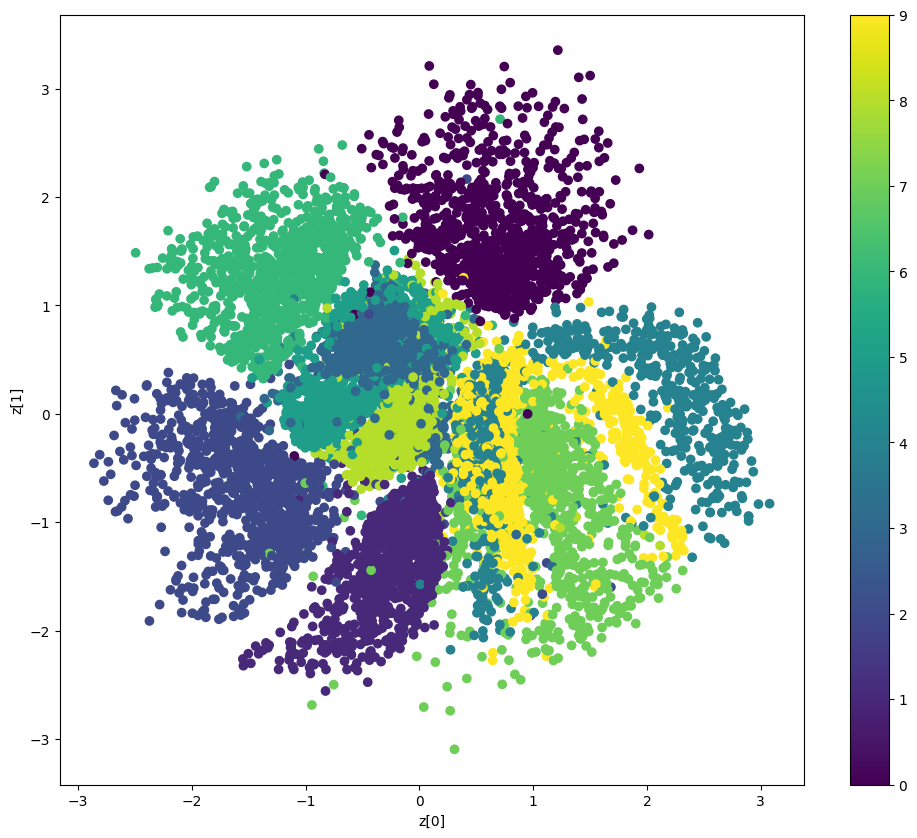

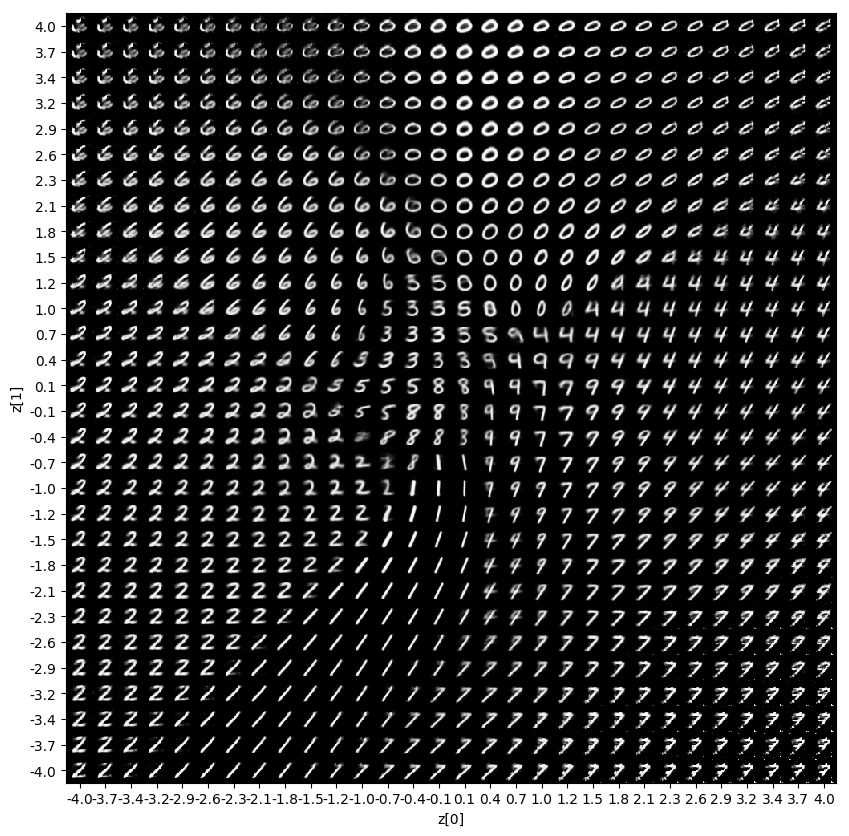

In [19]:
# plt.style.use('default')
batch_size = 100

def plot_results(encoder, decoder,
                 x_test, y_test,
                 batch_size=128):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        encoder (keras Model): encoder model
        decoder (keras Model): decoder model
        x_test (np.array): test data
        y_test (np.array): test labels
        batch_size (int): prediction batch size
    """

    # display a 2D plot of the digit classes in the latent space
    z_mean, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = x_test.shape[1]  # assume square images, i.e. height == width
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            x_decoded = np.reshape(x_decoded, (x_decoded.shape[0], -1))
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

# plot results
plot_results(encoder, decoder,
             x_test, y_test,
             batch_size=batch_size)

*These latent space plots can give an insight into the (latent) representations that are learned by the VAE. Evaluate what you see:*

**(a)** *Did you successfully train a generative model for this data? Motivate your answer.*



**Answer:**

Yes. We trained a model which doesn't use labels to get trained, thus, it's an unsupervised learning model and a generative one. The VAE is learning the data representation by finding the mean and log variance vectors, which explain the input data. In addition, with the parametrization trick is incorporating normalized noise into the encoding state of the input data, so that the reconstruction won't be exactly the same but slightly different. This make VAE a generalizable model.

**(b)** *Discuss how the latent space is populated by the test data. What happens in "gaps" in the latent space? I.e. areas in latent space near the origin (so with high prior likelihood) but without any data points being mapped to them. What do images generated from such latent points look like?*

**Answer:**

*  The latent space is populated with data in aggegated in clusters. The data points with parameters that look similar are clustered together in the latent space and not spaced arbitrarily, while the data points which are closer to those already in clusters are pushed further to form newer clusters. The distribution of data generation is based on the model learning the mean and standard deviation so that the transitions are not abrupt but continuous.

*   The presence of gaps in the latent space is equivalent to a model which has been trained in a supervised way with 'insufficient' data. So the model does not know those circumstances of the latent space or what to put in that space because no training has been done with the data which would have been probably mapped in those spaces. 

*  Images generated from such latent points will not belong to any specific or nearby class of the images the model has been trained with. They will be inspecific, blurry and random.

# Question 2: FashionMNIST VAE, semi-supervised learning

In this question, we will investigate the usefulness of VAE latent representations in semi-supervised learning. Since the VAE is an unsupervised method, we don't need any labels to learn latent representations. Often, it is easy to obtain a lot of unlabelled data, but labelling this data is expensive. Thus, methods that can leverage unsupervised training to learn a supervised goal (such as classification) may be very powerful. This is the idea behind semi-supervised learning.

You will evaluate this on the FashionMNIST dataset. Although all labels are available for this dataset, we can "hide" some labels from a model, simply by not using all of them.

Besides representations learned with a VAE, you will also compare with another representation learning method: a denoising autoencoder.

## Task 2.1: Unsupervised training
**(a)** *Train two representation learning methods on the FashionMNIST dataset; a variational autoencoder (VAE) and a denoising autoencoder. Choose a suitable architecture, and encoding/latent dimension (hint: for good results a dimension of 2 will likely be too small). For fairness, use similar architectures for each of the models.*

*Use each of the models to obtain encoded representations for the full dataset (training and test set).*

### 2.1. a) VAE

In [0]:
from keras.datasets import fashion_mnist

(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = fashion_mnist.load_data()

# normalise
x_train_fashion = x_train_fashion.astype('float32') / 255
x_test_fashion = x_test_fashion.astype('float32') / 255

# change shape: (n, 28, 28) -> (n, 28, 28, 1)
x_train_fashion = x_train_fashion.reshape(x_train_fashion.shape + (1,))
x_test_fashion = x_test_fashion.reshape(x_test_fashion.shape + (1,))

# pad zeros to obtain canvas size of 32x32, i.e. shape is now (n, 32, 32, 1)
x_train_fashion = np.pad(x_train_fashion, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)
x_test_fashion = np.pad(x_test_fashion, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)

# get height, width, and depth values
height_fashion, width_fashion, depth_fashion = x_train_fashion.shape[1:]

In [25]:
# VAE
# ENCODER

# network parameters
input_shape_fashion = (height_fashion, width_fashion, depth_fashion)
latent_dim_fashion = 32
dense1_dim_fashion = 1024
dense2_dim_fashion = 128

# VAE model = encoder + decoder
x_in_fashion = Input(shape=input_shape_fashion, name='encoder_input')

# build encoder model
# conv block 1
h = Conv2D(filters=64, kernel_size=(3, 3), padding="same",
           activation='relu')(x_in_fashion)                    # (32, 32, 1)  -> (32, 32, 64)
h = MaxPooling2D(pool_size=(2, 2), padding="same")(h)  # (32, 32, 64) -> (16, 16, 64)
h = BatchNormalization()(h)                            # no change

# conv block 2
h = Conv2D(filters=128, kernel_size=(3, 3), padding="same",
           activation='relu')(h)                       # (16, 16, 64)  -> (16, 16, 128)
h = MaxPooling2D(pool_size=(2, 2), padding="same")(h)  # (16, 16, 128) -> (8, 8, 128)
h = BatchNormalization()(h)                            # no change

# dense layers
h = Flatten()(h)                                       # (8, 8, 128) -> (8*8*128,)
h = Dense(dense1_dim_fashion, activation="relu")(h)                   # (8*8*128,)  -> (1024,)
h = BatchNormalization()(h)                            # no change
h = Dense(dense2_dim_fashion, activation="relu")(h)                    # (1024,) -> (64,)
h = BatchNormalization()(h)                            # no change
# h = Dense(32)(h)                                       # (64,) -> (32,) (encoding dimension)
# h = BatchNormalization()(h)                            # no change
####

z_mean_fashion = Dense(latent_dim_fashion, name='z_mean')(h)  # mean parameter of q(z|x)
z_log_var_fashion = Dense(latent_dim_fashion, name='z_log_var')(h)  # log of variance parameter of q(z|x)

# instantiate encoder model
encoder_fashion = Model(x_in_fashion, [z_mean_fashion, z_log_var_fashion], name='encoder')
encoder_fashion.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 32, 32, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 16, 16, 64)   256         max_pooling2d_9[0][0]            
__________________________________________________________________________________________________
conv2d_18 

In [27]:
# DECODER 
# build decoder model
z_in_fashion = Input(shape=(latent_dim_fashion,), name='z_in')

#### INSERT CODE HERE
h = Dense(dense2_dim_fashion, activation="relu")(z_in_fashion)      # (2,) -> (64,) (encoding dimension)
h = BatchNormalization()(h)                 # no change
h = Dense(dense1_dim_fashion, activation="relu")(h)        # (64, -> (1024,)
h = BatchNormalization()(h)                 # no change
h = Dense(8*8*128, activation="relu")(h)    # (1024,)     -> (8*8*128,)
h = Reshape((8, 8, 128))(h)                 # (8*8*128,) -> (8, 8, 128)

# reverse conv block 2
h = BatchNormalization()(h)                 # no change
h = UpSampling2D(size=(2, 2))(h)            # (8, 8, 128  ) -> (16, 16, 128)
h = Conv2D(filters=64, kernel_size=(3, 3), padding="same",
           activation='relu')(h)            # (16, 16, 128) -> (16, 16, 64)

# reverse conv block 2
h = BatchNormalization()(h)                 # no change
h = UpSampling2D(size=(2, 2))(h)            # (16, 16, 64) -> (32, 32, 64)

# do we need this one????
dec_out_fashion = Conv2D(filters=1, kernel_size=(3, 3), padding="same",
               activation='sigmoid')(h)     # (32, 32, 64) -> (32, 32, 1)


# instantiate decoder model
decoder_fashion = Model(z_in_fashion, dec_out_fashion, name='decoder')
decoder_fashion.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_in (InputLayer)            (None, 32)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               4224      
_________________________________________________________________
batch_normalization_41 (Batc (None, 128)               512       
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              132096    
_________________________________________________________________
batch_normalization_42 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_28 (Dense)             (None, 8192)              8396800   
_________________________________________________________________
reshape_6 (Reshape)          (None, 8, 8, 128)         0         
__________

In [62]:

## INTERMEDIATE LAYER connecting ENCODER-DECODER
# use reparametrisation trick to push the sampling out as input
z_fashion = Lambda(sampling, name='z')([z_mean_fashion, z_log_var_fashion])

# instantiate full VAE model
x_mean_fashion = decoder_fashion(z_fashion)
vae_fashion = Model(x_in_fashion, x_mean_fashion, name='vae')

# compile Model
vae_loss_fashion = VAE_loss(x_in_fashion, x_mean_fashion, z_mean_fashion, z_log_var_fashion)
vae_fashion.add_loss(vae_loss_fashion)
vae_fashion.compile(optimizer='adam')
vae_fashion.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 32, 32, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 16, 16, 64)   256         max_pooling2d_9[0][0]            
__________________________________________________________________________________________________
conv2d_18 

In [63]:
batch_size = 100
epochs = 50

# train the autoencoder
history_vae_fashion = vae_fashion.fit(x_train_fashion,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test_fashion, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 25s 422us/step - loss: 39.8012 - val_loss: 32.8805
Epoch 2/50
60000/60000 [==============================] - 21s 346us/step - loss: 30.5166 - val_loss: 28.3255
Epoch 3/50
60000/60000 [==============================] - 21s 346us/step - loss: 27.9831 - val_loss: 27.0231
Epoch 4/50
60000/60000 [==============================] - 21s 345us/step - loss: 26.8462 - val_loss: 25.9702
Epoch 5/50
60000/60000 [==============================] - 21s 343us/step - loss: 26.4039 - val_loss: 27.8060
Epoch 6/50
60000/60000 [==============================] - 21s 344us/step - loss: 25.8473 - val_loss: 26.0862
Epoch 7/50
60000/60000 [==============================] - 21s 345us/step - loss: 25.5555 - val_loss: 24.9570
Epoch 8/50
60000/60000 [==============================] - 21s 346us/step - loss: 25.3641 - val_loss: 25.9176
Epoch 9/50
60000/60000 [==============================] - 21s 344us/step - los

### 2.1. b) DAE

In [80]:
#Noise
noise_factor = 0.5
x_train_fashion_noisy = x_train_fashion + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_fashion.shape) 
x_test_fashion_noisy = x_test_fashion + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_fashion.shape) 

x_train_fashion_noisy = np.clip(x_train_fashion_noisy, 0., 1.)
x_test_fashion_noisy = np.clip(x_test_fashion_noisy, 0., 1.)


# DAE
DAE = Sequential()

# encoder
DAE.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape_fashion))
DAE.add(MaxPooling2D((2, 2), padding='same'))
DAE.add(BatchNormalization())
DAE.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
DAE.add(MaxPooling2D((2, 2), padding='same'))  # at this point the representation is (7, 7, 32)
DAE.add(BatchNormalization())
DAE.add(Flatten())  # the representation is now a flat vector of dimension 7*7*32 = 1568
DAE.add(Dense(dense1_dim_fashion, activation='relu', name="dense1"))  # name this "neural_codes" to retrieve as codes later
DAE.add(BatchNormalization())
DAE.add(Dense(dense2_dim_fashion, activation='relu', name="dense2"))  # name this "neural_codes" to retrieve as codes later
DAE.add(BatchNormalization())
DAE.add(Dense(latent_dim_fashion, activation='relu', name="neural_codes")) 

# decoder
DAE.add(Dense(dense2_dim_fashion, activation='relu', name="dense2_dec"))  # obtain representation that can be reshaped to (7, 7, 32)
DAE.add(BatchNormalization())
DAE.add(Dense(dense1_dim_fashion, activation='relu', name="dense1_dec"))  # obtain representation that can be reshaped to (7, 7, 32)
DAE.add(BatchNormalization())
DAE.add(Dense(8*8*128, activation='relu', name="dense_upscale"))
DAE.add(Reshape((8, 8, 128)))
DAE.add(BatchNormalization())
DAE.add(UpSampling2D((2, 2)))
DAE.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
DAE.add(BatchNormalization())
DAE.add(UpSampling2D((2, 2)))
DAE.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

DAE.summary()
DAE.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 32, 32, 64)        640       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_81 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_82 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
flatten_15 (Flatten)         (None, 8192)              0         
__________

In [81]:
# training the DAE
batch_size = 100
epochs = 10

history_DAE = DAE.fit(x_train_fashion_noisy, x_train_fashion,
                batch_size=batch_size,
                epochs=epochs,
                validation_split=1/12)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 27s 482us/step - loss: 0.2631 - val_loss: 0.2333
Epoch 2/10
55000/55000 [==============================] - 20s 355us/step - loss: 0.2287 - val_loss: 0.2273
Epoch 3/10
55000/55000 [==============================] - 19s 353us/step - loss: 0.2245 - val_loss: 0.2262
Epoch 4/10
55000/55000 [==============================] - 19s 354us/step - loss: 0.2217 - val_loss: 0.2247
Epoch 5/10
55000/55000 [==============================] - 19s 354us/step - loss: 0.2200 - val_loss: 0.2234
Epoch 6/10
55000/55000 [==============================] - 19s 353us/step - loss: 0.2182 - val_loss: 0.2234
Epoch 7/10
55000/55000 [==============================] - 19s 354us/step - loss: 0.2169 - val_loss: 0.2238
Epoch 8/10
55000/55000 [==============================] - 19s 353us/step - loss: 0.2155 - val_loss: 0.2225
Epoch 9/10
55000/55000 [==============================] - 19s 354us/step - loss: 0.2144 - val_l

**(b)** *Motivate your architectural choices.*

**Answer:**

*   For the VAE we followed a similar architecture than in Question 1, however since the images of MNIST_fashion are more complex than the digits of MNIST, we need a richer latent space, which needs to be of a dimension higher than 2. We chose a dimension of 32 for our encoding state. Therefore, we need to downscale more gradually from the Flatten layer to the latent state. We use a first dense layer of 1024, a second of 128 which is connected to the encoding state of 32. For the decoder we do a symetric architecture of the encoder.

*   For the DAE we followed the architecture created for the VAE, to have a fair comparison between the two models. Indeed, the unique difference between both of them is how in the VAE the z is sampled with the reparametrization trick, while in the DAE that z is directly connected to the decoder. But, architecture-wise (encoder and decoder separately) both models are the same.





## Task 2.2: Qualitative evaluation
Plotting the population of the latent space only works for a 2-dimensional latent space. For higher dimensions, we need different ways to qualitatively evaluate the models.

**(a)** *Reconstruct some images from the test set with both the VAE and DAE. Plot the reconstructions alongside the original images. Briefly discuss the results.*


In [0]:
# a) Reconstruct some images from the test set with both the VAE and DAE
def plot_examples(x):
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(x[i].reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


### a1) VAE reconstruction

10000/10000 [==============================] - 1s 88us/step
Test loss VAE: 22.647474


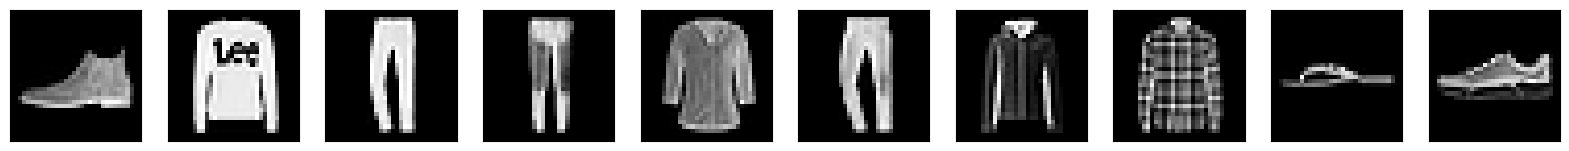

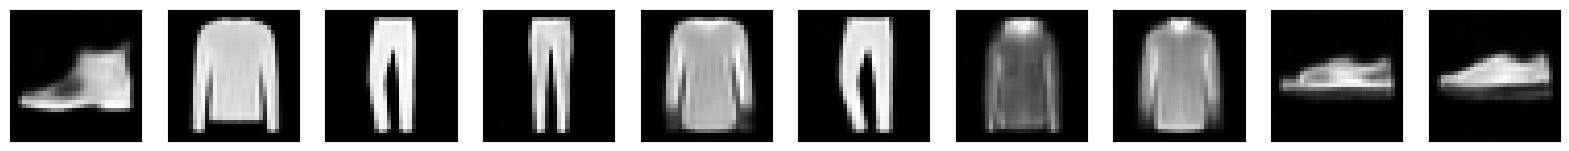

In [86]:
# VAE    
test_loss_VAE = vae_fashion.evaluate(x_test_fashion, batch_size=batch_size)
print("Test loss VAE:", test_loss_VAE[-1])

x_test_reconstr_VAE = vae_fashion.predict(x_test_fashion, batch_size=batch_size)

plot_examples(x_test_fashion)
plot_examples(x_test_reconstr_VAE)

### a2) DAE reconstruction

10000/10000 [==============================] - 1s 97us/step
Test loss: 0.2230494424700737


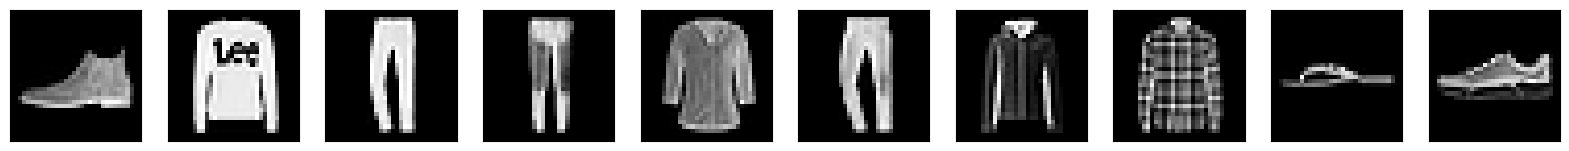

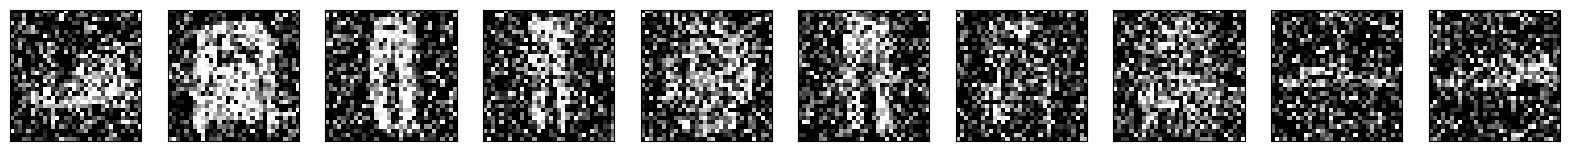

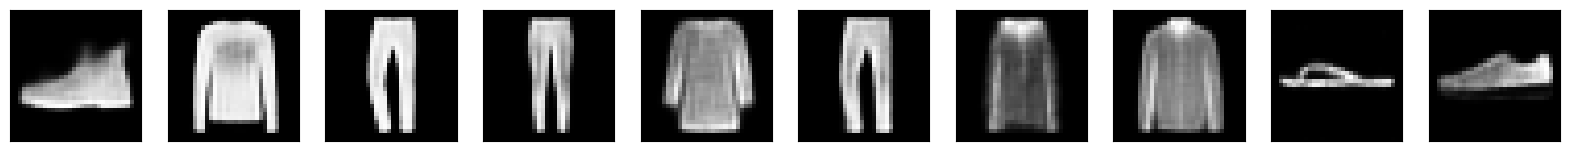

In [83]:

# DAE    
test_loss_DAE = DAE.evaluate(x_test_fashion_noisy, x_test_fashion, batch_size=batch_size)
print("Test loss DAE:", test_loss_DAE)

x_test_reconstr_DAE = DAE.predict(x_test_fashion_noisy, batch_size=batch_size)

plot_examples(x_test_fashion)
plot_examples(x_test_fashion_noisy)
plot_examples(x_test_reconstr_DAE)


**(b)** *The VAE is a generative model; generate some images with the VAE and visualise them. Also try to generate images with the DAE (even though it is not intended as a generative model) and visualise them. Discuss the results, in particular the difference between VAE and DAE.*

### b1) VAE generating images from the latent space. z is created with random uniform noise.

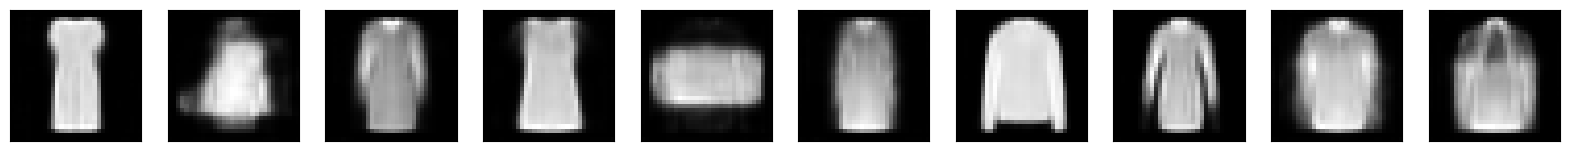

In [97]:
n = 10
# digit_size = 128
list_images_generated_VAE = []

for i in range(n):
  z_sample = np.array([np.random.uniform(-1, size=latent_dim_fashion)])
  x_decoded = decoder_fashion.predict(z_sample)
  image = x_decoded[0].reshape(height_fashion, width_fashion, depth_fashion)
  #         figure[i * height_fashion: (i + 1) * height_fashion,j * height_fashion: (j + 1) * height_fashion] = image\
  list_images_generated_VAE.append(image)
        
list_images_generated_VAE = np.asarray(list_images_generated_VAE)
plot_examples(list_images_generated_VAE)

### b2) VAE generating images from the feature space. x (input image) is created with random uniform noise.

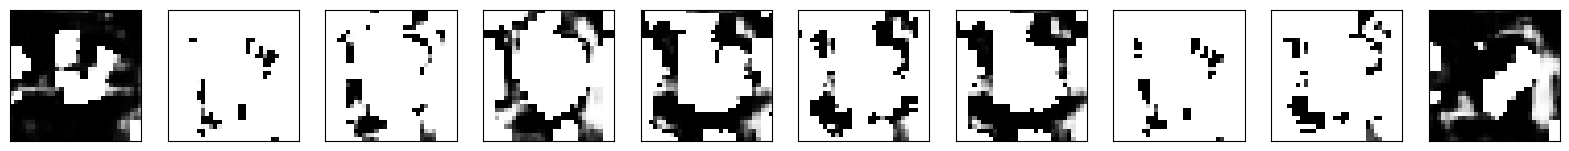

In [104]:
n = 10
# digit_size = 128
list_images_generated_VAE_full = []

for i in range(n):
  x_sample = np.array([np.random.uniform(-1, size=(height_fashion, width_fashion, depth_fashion))])
  x_decoded = vae_fashion.predict(x_sample)
  image = x_decoded[0].reshape(height_fashion, width_fashion, depth_fashion)
  #         figure[i * height_fashion: (i + 1) * height_fashion,j * height_fashion: (j + 1) * height_fashion] = image\
  list_images_generated_VAE_full.append(image)
        
list_images_generated_VAE_full = np.asarray(list_images_generated_VAE_full)
plot_examples(list_images_generated_VAE_full)

### b3) DAE generating images from the feature space. x (input image) is created with random uniform noise.

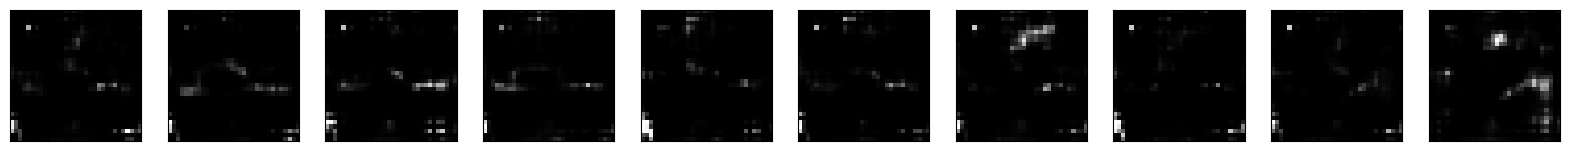

In [105]:
n = 10
# digit_size = 128
list_images_generated_DAE = []

for i in range(n):
  x_sample = np.array([np.random.uniform(-1, size=(height_fashion, width_fashion, depth_fashion))])
  x_decoded = DAE.predict(x_sample)
  image = x_decoded[0].reshape(height_fashion, width_fashion, depth_fashion)
  #         figure[i * height_fashion: (i + 1) * height_fashion,j * height_fashion: (j + 1) * height_fashion] = image\
  list_images_generated_DAE.append(image)
        
list_images_generated_DAE = np.asarray(list_images_generated_DAE)
plot_examples(list_images_generated_DAE)

*Discuss the results:*

*   The DAE since it's not a generative model cannot create any image, just black backgrounds with some random white pixels.
*   When we try to generate images from feature space (x) with the VAE, since the input images are just a random values for pixels, the generated image is not clear. So, we can say that the result is also a random image. However, we can appreciate that the VAE captures better and displays certain shapes and patterns.
* However, when we generate images by just calling the VAE's decoder, which is taking as input random values for the latent state matrix (z) we actually see new images of clothes (similar to the rest of the MNIST_fashion datasets). This means, that the decoder is using the learnt weights and is creating a new image from a random uniform provided in the latent space.



## Task 2.3: Semi-supervised learning
*Perform a thorough evaluation of semi-supervised learning for representations learned with your variational and denoising autoencoders.*

*Guidelines:*
* For various suitable values of $l$, randomly select $l$ instances from the training dataset, these will represent your labelled data and are the only data points that may be used for supervised learning. Make sure to include $l=60000$ (i.e. the entire dataset).
* For each value of $l$, train a few off-the-shelf methods from scikit-learn (e.g. random forest, SVM) as well as a simple multilayer perception (MLP) on representations from both the VAE and DAE, using only the $l$ available labels.
* For each value of $l$, also train an MLP on the original image data, using only the $l$ available labels.
* Visualise your results in a clear way, and report your conclusions. Was it beneficial to use unlabelled data as well as labelled data? Which representations worked best?

In [0]:
#### insert code here

####

**Motivation & Conclusions:** *Explain your analysis, and draw conclusions:*